In [2]:
import os

try:
    snakemake
except NameError:
    from snakemk_util import load_rule_args
    
    os.chdir('../..')
    
    snakemake = load_rule_args(
        snakefile = os.getcwd() + "/workflow/Snakefile",
        rule_name = 'lapa_pilot_atlas',
        root = '..',
    )

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from lapa.result import LapaResult
from collections import Counter
import matplotlib.pyplot as plt
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import multipletests

tqdm.pandas()

In [4]:
result = LapaResult(snakemake.input['long_reads'])
samples = result.samples

In [96]:
df = list()

for i in tqdm(samples):
    _df = result.read_apa(i)
    _df = _df[_df['count'] > 3]   
    _df = _df[['Chromosome', 'polyA_site', 'Feature', 'Strand']]
    _df['Cell lines'] = '_'.join(i.split('_')[:-2])
    df.append(_df)

df = pd.concat(df)

  0%|          | 0/51 [00:00<?, ?it/s]

In [97]:
df = df.groupby(['Feature', 'Cell lines']).size().reset_index().rename(columns={0: 'count'})

In [98]:
df = df.set_index('Cell lines').join(df.groupby('Cell lines').agg('sum'), rsuffix='_total')
df['Percentage'] = df['count'] / df['count_total']

In [99]:
df

,Feature,count,count_total,Percentage
Cell lines,,,,
gm12878,exon,13171,102857,0.128052
gm12878,intron,4465,102857,0.043410
gm12878,three_prime_utr,85221,102857,0.828539
gm23338,exon,3328,23469,0.141804
gm23338,intron,440,23469,0.018748
...,...,...,...,...
pgp1_excite_neuron,intron,690,20888,0.033033
pgp1_excite_neuron,three_prime_utr,17711,20888,0.847903
wtc11,exon,3789,74415,0.050917


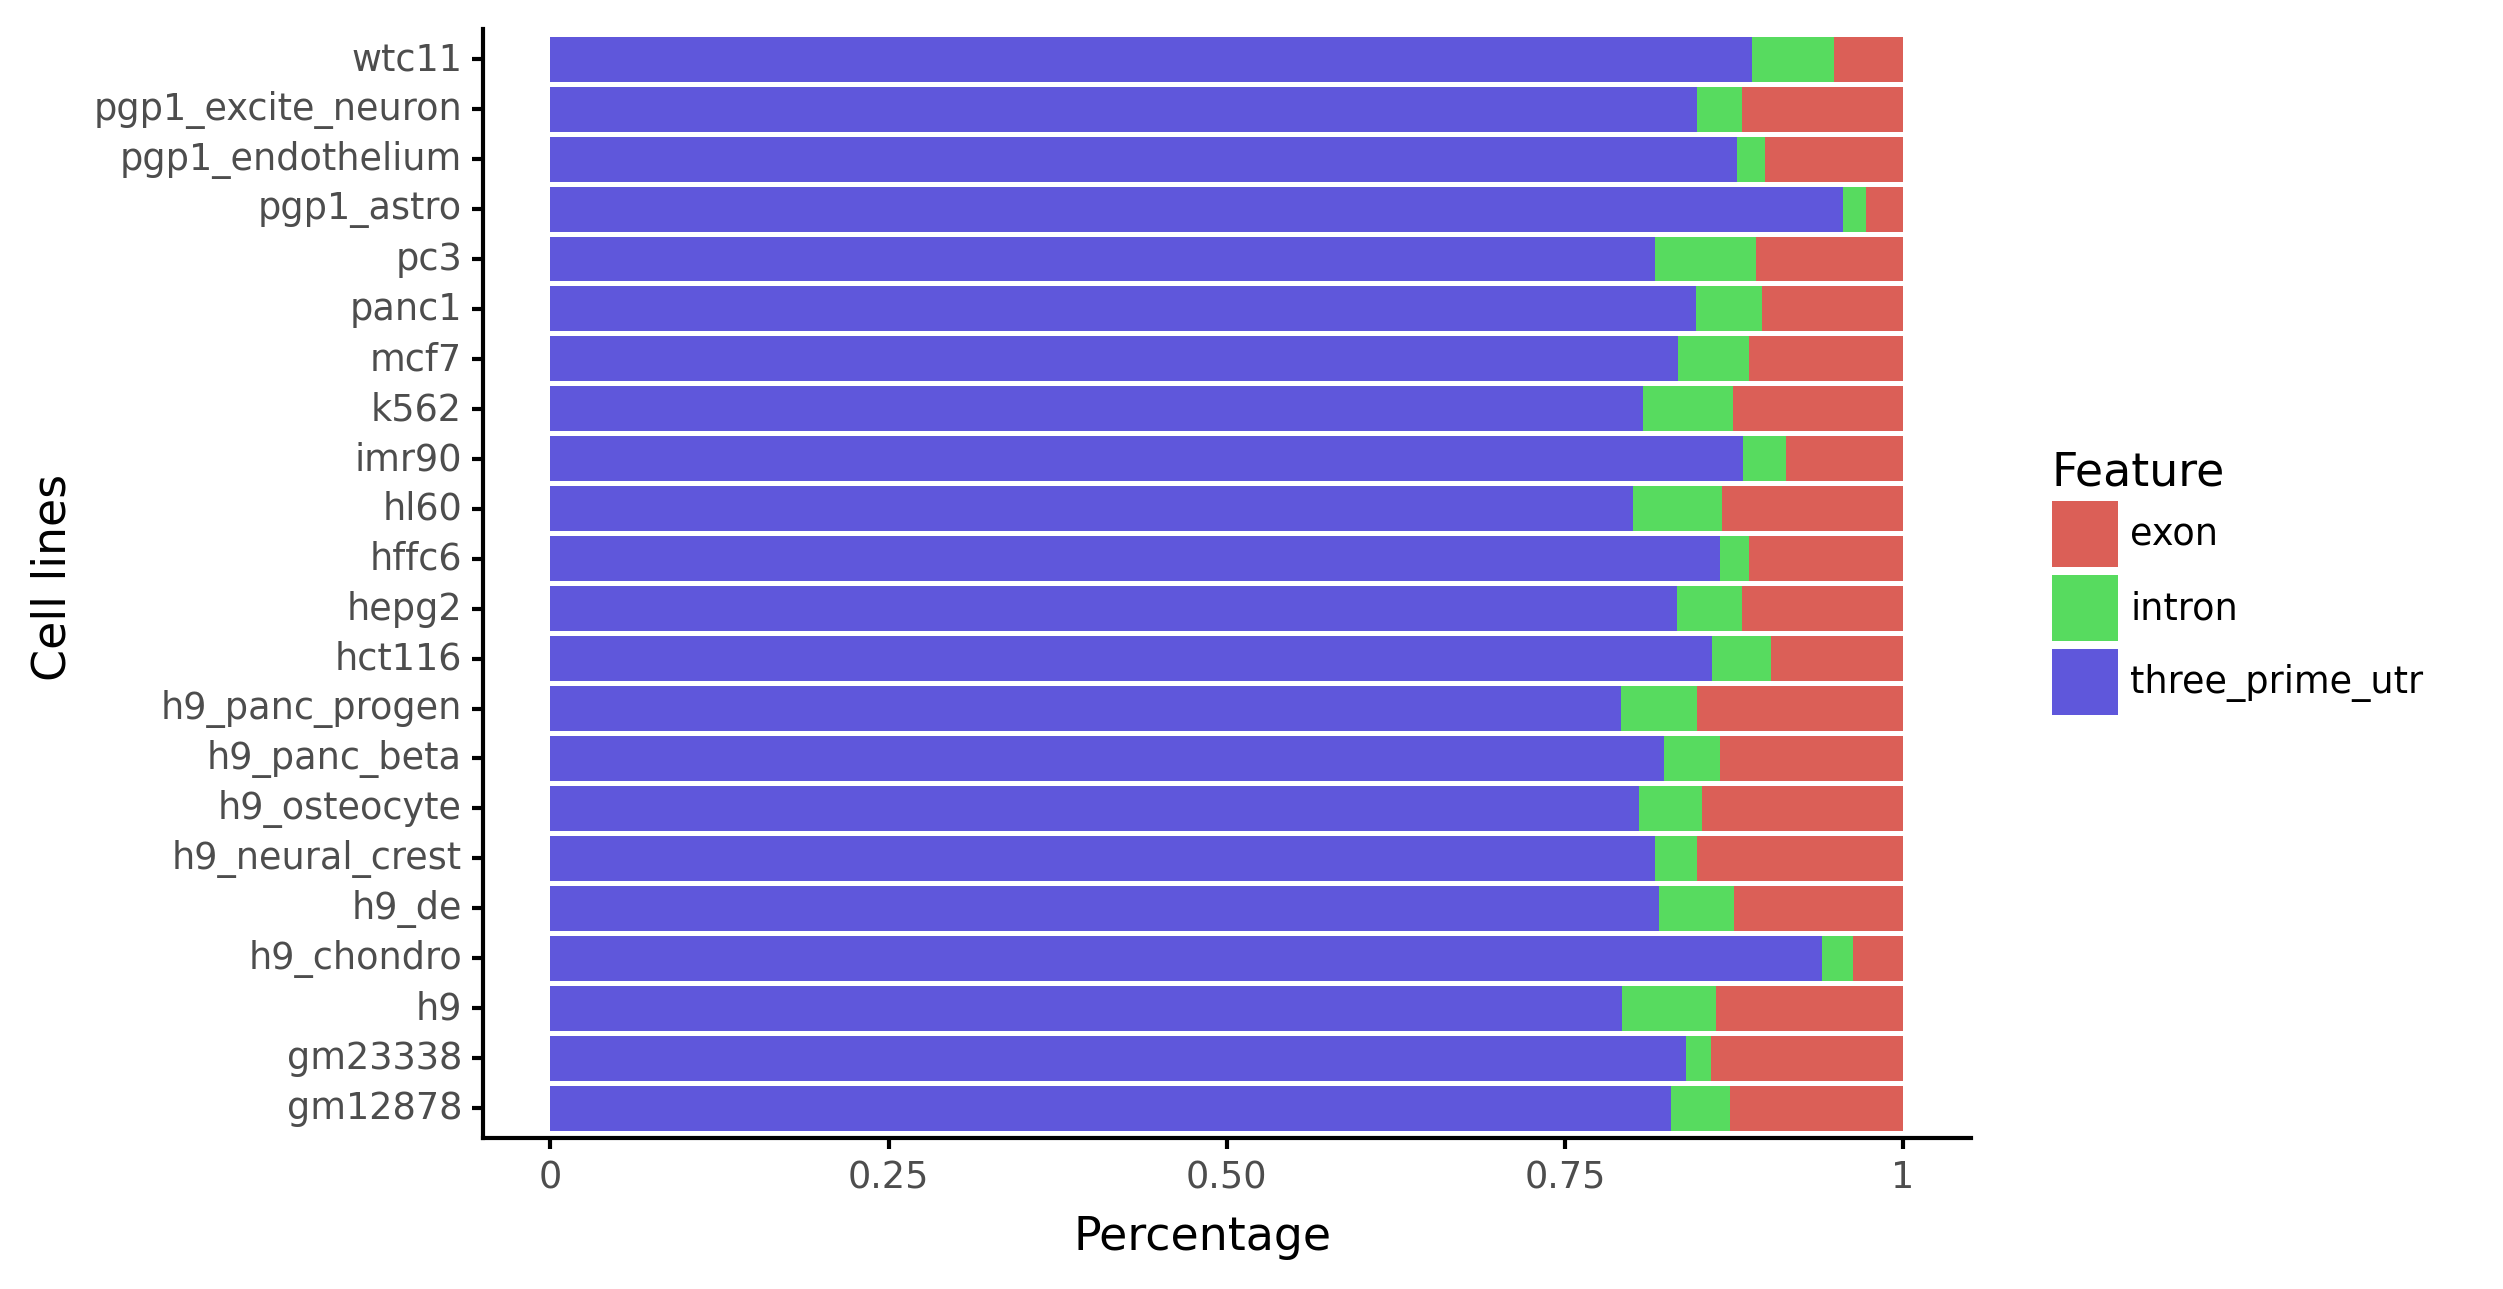

<ggplot: (8771288169973)>

In [103]:
import plotnine

plotnine.options.dpi = 300

(ggplot(df.reset_index(), aes(x='Cell lines', y='Percentage', fill='Feature'))
 + geom_col()
 + coord_flip()
 + theme_classic() 
)

In [18]:
gr_lapa = pr.PyRanges(result.read_cluster())

In [78]:
import pyranges as pr

In [88]:
gr_gtf = pr.PyRanges(pd.read_csv('data/results/common/human_tes.csv'))
gr_gtf = gr_gtf[gr_gtf.gene_type.isin({'lncRNA' , 'protein_coding'})].merge()

In [128]:
df = gr_lapa.nearest(gr_gtf)
num_gtf_lapa = df[df.Distance < 50].df.shape[0]

In [94]:
gr_atlas = pr.read_bed('data/resources/common/human/atlas.clusters.2.0.GRCh38.96.bed.gz', as_df=True)
gr_atlas['Chromosome'] = 'chr' + gr_atlas['Chromosome'].astype('str')
gr_atlas = pr.PyRanges(gr_atlas)

/data/homezvol2/mcelik/.conda/envs/lapa/lib/python3.7/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.


In [102]:
df = gr_atlas.nearest(gr_gtf)
df = df[df.Distance < 50]
num_gtf_atlas = df.df.shape[0]

In [136]:
df = gr_lapa.nearest(gr_gtf)
df = df[df.Distance < 50]
df = df.drop().nearest(gr_atlas.drop())
df = df[df.Distance < 50]
num_all = df.df.shape[0]

In [107]:
df = gr_atlas.nearest(gr_lapa)
df = df[df.Distance < 50]
num_lapa_atlas = df.df.shape[0]

In [132]:
num_lapa_atlas

128796

In [133]:
num_gtf_lapa

44223

In [137]:
num_all

35179

In [146]:
from venn import venn

venn(subsets = (
    gr_lapa.df.shape[0] - num_gtf_lapa - num_lapa_atlas - num_all,
    gr_gtf.df.shape[0] - num_gtf_lapa - num_gtf_atlas - num_all,
    num_gtf_lapa - num_all,
    gr_atlas.df.shape[0] - num_gtf_atlas - num_lapa_atlas - num_all,
    num_lapa_atlas - num_all,
    num_gtf_atlas - num_all,
    num_all
), set_labels = ('Set1', 'Set2', 'Set3'))

TypeError: venn_dispatch() got an unexpected keyword argument 'subsets'